In [1]:
import pandas as pd

def load_and_prepare_oil_data(filepath):
    """
    Load oil price data from CSV, parse dates, and prepare for time series analysis.

    Parameters:
        filepath (str): File path to the oil_prices.csv dataset.

    Returns:
        pd.DataFrame: Time series DataFrame indexed by datetime with cleaned 'Price' values.
    """
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
    df = df.sort_values('Date').dropna()     # Ensure chronological order and drop missing values
    df.set_index('Date', inplace=True)       # Set 'Date' as the index for time series compatibility
    return df

# Define the file path (update this once the dataset is uploaded)
file_path = "oil_price.csv"

# Load and prepare the oil price dataset
oil_df_lstm = load_and_prepare_oil_data(file_path)

# Basic inspection
print("DataFrame shape:", oil_df_lstm.shape)
print("Preview of cleaned dataset:")
print(oil_df_lstm.head())


DataFrame shape: (635, 1)
Preview of cleaned dataset:
            Price
Date             
2020-07-01  42.18
2020-07-02  43.19
2020-07-03  42.92
2020-07-06  42.73
2020-07-07  43.28


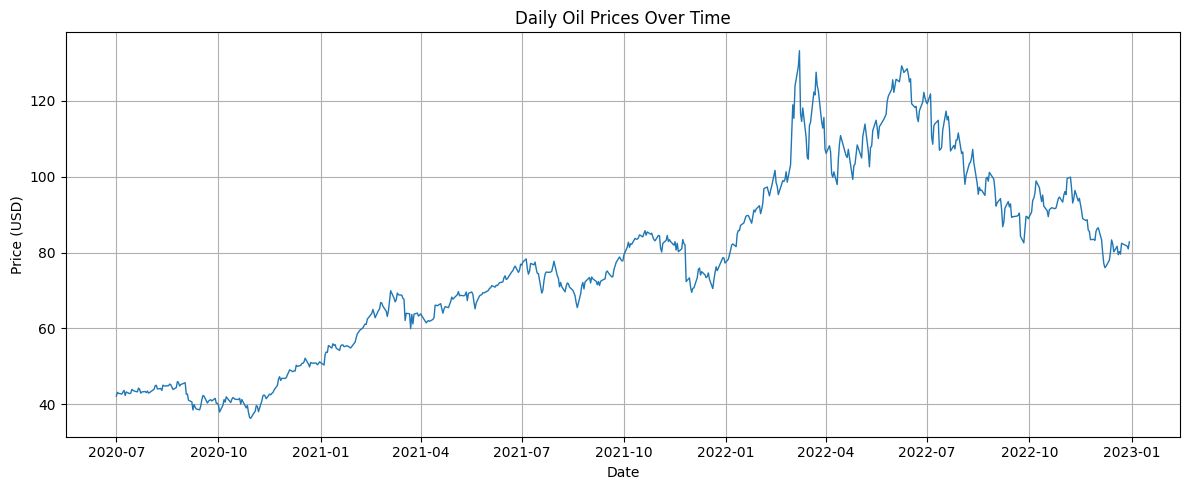

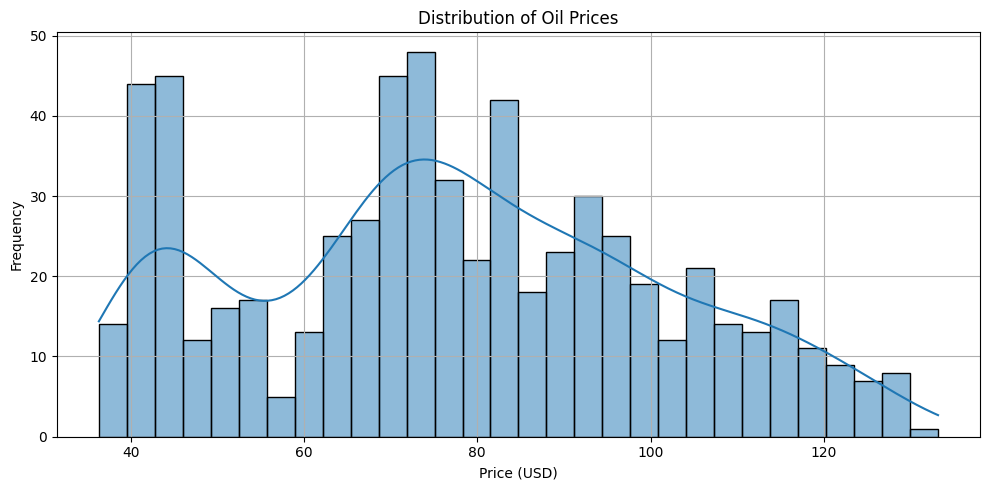

/tmp/ipython-input-2-491651898.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['Price'].resample('M').mean()


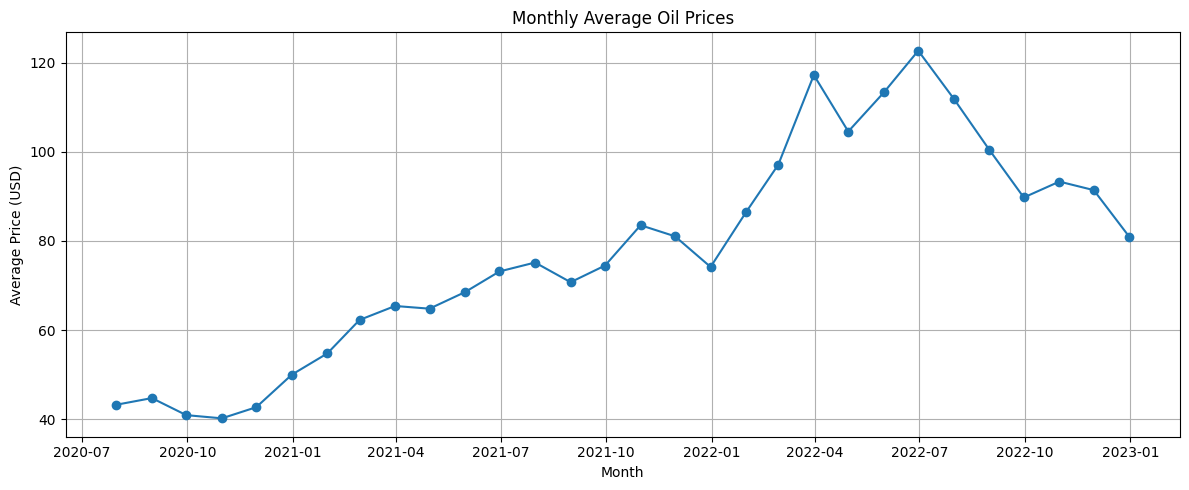

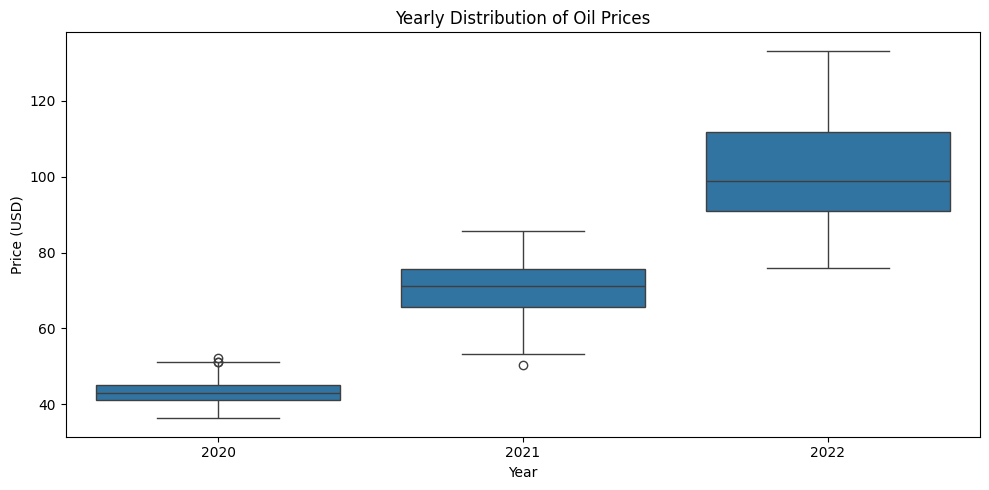

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_oil_price_over_time(df):
    """
    Plot the daily oil prices over time.

    Parameters:
        df (pd.DataFrame): Time-indexed DataFrame containing 'Price'.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Price'], linewidth=1)
    plt.title("Daily Oil Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_price_distribution(df):
    """
    Plot histogram with KDE to show price distribution.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Price'.
    """
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Price'], bins=30, kde=True)
    plt.title("Distribution of Oil Prices")
    plt.xlabel("Price (USD)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_monthly_avg_price(df):
    """
    Plot monthly average oil prices.

    Parameters:
        df (pd.DataFrame): Time-indexed DataFrame with daily prices.
    """
    monthly_avg = df['Price'].resample('M').mean()
    plt.figure(figsize=(12, 5))
    plt.plot(monthly_avg.index, monthly_avg, marker='o')
    plt.title("Monthly Average Oil Prices")
    plt.xlabel("Month")
    plt.ylabel("Average Price (USD)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_annual_boxplot(df):
    """
    Plot boxplot of oil prices grouped by year.

    Parameters:
        df (pd.DataFrame): Time-indexed DataFrame containing 'Price'.
    """
    df_copy = df.copy()
    df_copy['Year'] = df_copy.index.year
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Year', y='Price', data=df_copy)
    plt.title("Yearly Distribution of Oil Prices")
    plt.xlabel("Year")
    plt.ylabel("Price (USD)")
    plt.tight_layout()
    plt.show()

# Run EDA plots
plot_oil_price_over_time(oil_df_lstm)
plot_price_distribution(oil_df_lstm)
plot_monthly_avg_price(oil_df_lstm)
plot_annual_boxplot(oil_df_lstm)


ADF Test on Original Series:
ADF Statistic: -1.598608589550151
p-value: 0.48429238915100054
Critical Values: {'1%': np.float64(-3.440975679277454), '5%': np.float64(-2.8662281164567927), '10%': np.float64(-2.5692666752547626)}
Stationary: False

First differencing applied.
ADF Test on Differenced Series:
ADF Statistic: -5.278578124041285
p-value: 6.0637563460194175e-06
Critical Values: {'1%': np.float64(-3.440975679277454), '5%': np.float64(-2.8662281164567927), '10%': np.float64(-2.5692666752547626)}
Stationary: True


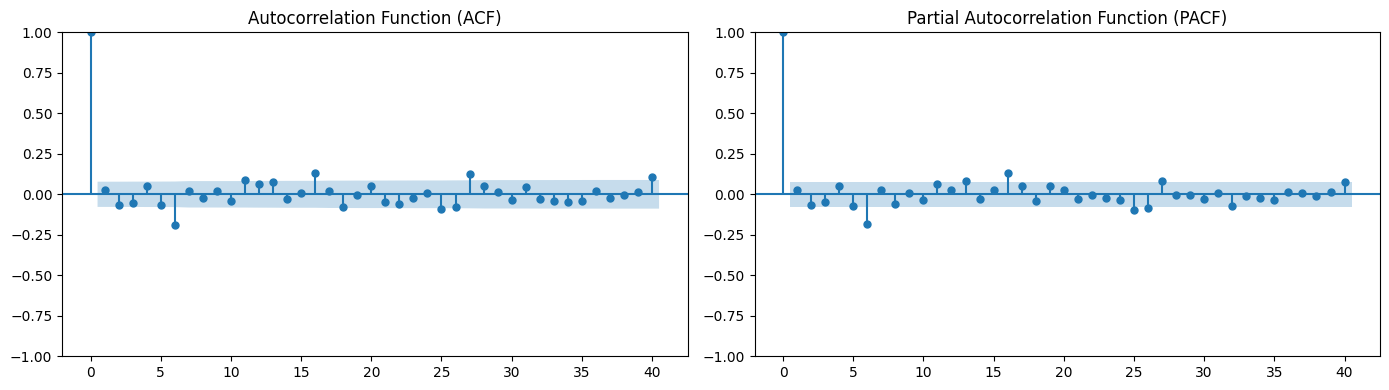

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def run_adf_test(series, signif=0.05):
    """
    Perform Augmented Dickey-Fuller test to assess stationarity.

    Parameters:
        series (pd.Series): Time series values.
        signif (float): Significance level for hypothesis test.

    Returns:
        dict: ADF test results and interpretation.
    """
    result = adfuller(series, autolag='AIC')
    output = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4],
        'Stationary': result[1] < signif
    }
    return output

def plot_acf_pacf(series, lags=40):
    """
    Plot ACF and PACF for a given series.

    Parameters:
        series (pd.Series): The time series to analyze.
        lags (int): Number of lags to show.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(series, lags=lags, ax=axes[0])
    plot_pacf(series, lags=lags, ax=axes[1], method='ywm')
    axes[0].set_title("Autocorrelation Function (ACF)")
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    plt.tight_layout()
    plt.show()

# Apply ADF test on original data
original_adf_result = run_adf_test(oil_df_lstm['Price'])

print("ADF Test on Original Series:")
for key, value in original_adf_result.items():
    print(f"{key}: {value}")

# If non-stationary, apply first differencing
if not original_adf_result['Stationary']:
    oil_df_lstm['Price_diff'] = oil_df_lstm['Price'].diff().dropna()
    print("\nFirst differencing applied.")
    differenced_series = oil_df_lstm['Price_diff'].dropna()
    differenced_adf_result = run_adf_test(differenced_series)

    print("ADF Test on Differenced Series:")
    for key, value in differenced_adf_result.items():
        print(f"{key}: {value}")

    # Plot ACF and PACF of differenced series
    plot_acf_pacf(differenced_series)
else:
    print("No differencing required.")
    plot_acf_pacf(oil_df_lstm['Price'])


In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Use first-differenced data for stationarity
oil_df_alt = oil_df_lstm.copy()  # working on the new assignment version
oil_df_alt['Price_diff'] = oil_df_alt['Price'].diff()
stationary_series_alt = oil_df_alt['Price_diff'].dropna()

# Define a simple ARIMA model (initial guess before fine-tuning)
initial_order = (1, 1, 1)  # common starting point

# Fit the model
print(f"Fitting initial ARIMA model with order: {initial_order}")
initial_model = ARIMA(oil_df_alt['Price'], order=initial_order)
initial_result = initial_model.fit()

# Print model summary
print(initial_result.summary())


Fitting initial ARIMA model with order: (1, 1, 1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  635
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1416.066
Date:                Fri, 04 Jul 2025   AIC                           2838.131
Time:                        22:28:19   BIC                           2851.487
Sample:                             0   HQIC                          2843.318
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3130      0.576     -0.543      0.587      -1.442       0.816
ma.L1          0.3503      0.568      0.616      0.538      -0.764       1.464
sigma2         5.0998      0.139     36.574      0.0

In [5]:
from statsmodels.tsa.arima.model import ARIMA

def fit_initial_arima_model(series, order=(1, 1, 1)):
    """
    Fit a basic ARIMA model to the provided time series.

    Parameters:
        series (pd.Series): The original time series (non-stationary or differenced).
        order (tuple): The (p, d, q) order for ARIMA.

    Returns:
        ARIMAResults: Fitted model object.
    """
    print(f"Fitting ARIMA model with order: {order}")
    model = ARIMA(series, order=order)
    result = model.fit()
    print("Model fitting completed.\n")
    print(result.summary())
    return result

# Apply first-order differencing to ensure stationarity
oil_df_alt = oil_df_lstm.copy()
oil_df_alt['Price_diff'] = oil_df_alt['Price'].diff()
stationary_series_alt = oil_df_alt['Price_diff'].dropna()

# Fit the model using a standard initial configuration
initial_arima_result = fit_initial_arima_model(oil_df_alt['Price'], order=(1, 1, 1))


Fitting ARIMA model with order: (1, 1, 1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model fitting completed.

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  635
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1416.066
Date:                Fri, 04 Jul 2025   AIC                           2838.131
Time:                        22:28:25   BIC                           2851.487
Sample:                             0   HQIC                          2843.318
                                - 635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3130      0.576     -0.543      0.587      -1.442       0.816
ma.L1          0.3503      0.568      0.616      0.538      -0.764       1.464
sigma2         5.0998     

In [ ]:
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

def grid_search_arima_aic(series, p_range, d_range, q_range):
    """
    Perform grid search over ARIMA(p,d,q) parameters to find the model with lowest AIC.

    Parameters:
        series (pd.Series): Time series data (should be stationary or differenced).
        p_range (range): Values to try for AR term p.
        d_range (range): Values to try for differencing d.
        q_range (range): Values to try for MA term q.

    Returns:
        tuple: (best_order, best_aic) where best_order is (p,d,q)
    """
    best_aic = np.inf
    best_order = None

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                except:
                    continue  # Skip combinations that fail to converge
    return best_order, best_aic

# Define parameter search space
p_values = range(0, 9)
d_values = range(0, 3)
q_values = range(0, 9)

# Run grid search on original series (not differenced — differencing is part of model)
best_arima_order, best_model_aic = grid_search_arima_aic(
    oil_df_alt['Price'].dropna(), p_values, d_values, q_values
)

print("Best ARIMA model order based on AIC:", best_arima_order)
print("Lowest AIC value:", round(best_model_aic, 2))


Best ARIMA model order based on AIC: (6, 1, 7)
Lowest AIC value: 2808.38


[*********************100%***********************]  1 of 1 completed


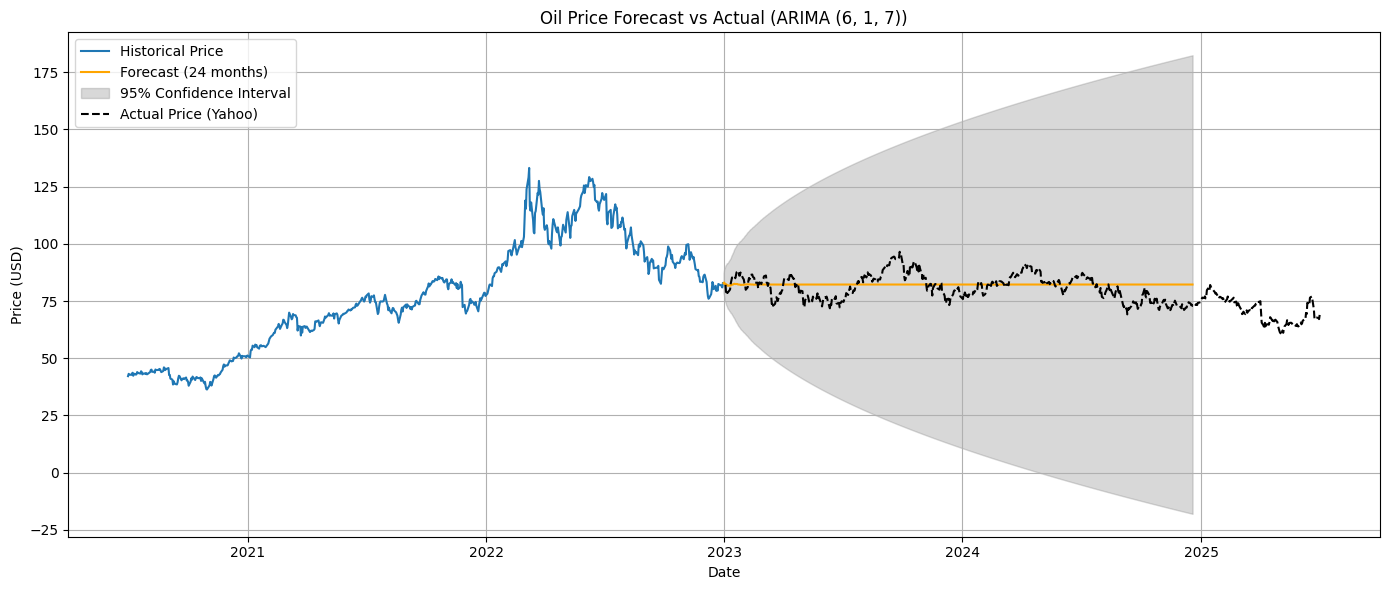

Root Mean Squared Error (RMSE): 5.66 USD


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# ----------------------- Function Definitions -----------------------

def forecast_arima_model(model_fit, steps_ahead=720):
    """
    Forecast future values using a fitted ARIMA model.

    Args:
        model_fit: Trained ARIMA model.
        steps_ahead (int): Number of future steps to forecast.

    Returns:
        forecast_mean (pd.Series): Mean forecast values.
        conf_int (pd.DataFrame): Confidence intervals.
        forecast_index (pd.DatetimeIndex): Corresponding future dates.
    """
    forecast = model_fit.get_forecast(steps=steps_ahead)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    last_date = oil_df_alt.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps_ahead, freq='D')
    forecast_mean.index = forecast_index
    conf_int.index = forecast_index
    return forecast_mean, conf_int, forecast_index

def download_actual_prices(start_date, end_date):
    """
    Download actual oil prices for evaluation using Yahoo Finance.

    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Interpolated actual price series.
    """
    raw = yf.download("BZ=F", start=start_date, end=end_date)
    if 'Adj Close' in raw.columns:
        prices = raw[['Adj Close']].rename(columns={'Adj Close': 'Price'})
    elif 'Close' in raw.columns:
        prices = raw[['Close']].rename(columns={'Close': 'Price'})
    else:
        raise ValueError("No valid price column found.")
    prices.index = pd.to_datetime(prices.index)
    prices = prices.asfreq('D').interpolate()
    return prices

def evaluate_forecast(actual_series, forecast_series):
    """
    Calculate RMSE between actual and forecasted series.

    Args:
        actual_series (pd.Series): Actual observed values.
        forecast_series (pd.Series): Forecasted values.

    Returns:
        float: RMSE score.
    """
    df_eval = pd.DataFrame({'actual': actual_series, 'forecast': forecast_series}).dropna()
    return sqrt(mean_squared_error(df_eval['actual'], df_eval['forecast']))

# ----------------------- Model Fitting & Forecast -----------------------

# Define best ARIMA order from earlier tuning
best_order = (6, 1, 7)

# Fit ARIMA model on historical data
best_arima_model = ARIMA(oil_df_alt['Price'], order=best_order).fit()

# Forecast 24 months into future
forecast_mean, conf_int, forecast_index = forecast_arima_model(best_arima_model)

# Download actual prices to compare
start_dt = forecast_index[0].strftime('%Y-%m-%d')
end_dt = pd.to_datetime("today").strftime('%Y-%m-%d')
actual_prices_df = download_actual_prices(start_dt, end_dt)

# Align forecast and actual for evaluation
common_dates = actual_prices_df.index.intersection(forecast_mean.index)
actual_series = actual_prices_df['Price'].reindex(common_dates).squeeze()
forecast_series = forecast_mean.reindex(common_dates).squeeze()
rmse_score = evaluate_forecast(actual_series, forecast_series)

# ----------------------- Plotting -----------------------

plt.figure(figsize=(14, 6))
plt.plot(oil_df_alt['Price'], label="Historical Price")
plt.plot(forecast_index, forecast_mean, label="Forecast (24 months)", color='orange')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='gray', alpha=0.3, label="95% Confidence Interval")
plt.plot(actual_prices_df.index, actual_prices_df['Price'], '--', color='black', label="Actual Price (Yahoo)")
plt.title(f"Oil Price Forecast vs Actual (ARIMA {best_order})")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output RMSE
print(f"Root Mean Squared Error (RMSE): {rmse_score:.2f} USD")


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_forecast(actual_series, forecast_series):
    """
    Evaluate forecast accuracy using multiple metrics.

    Args:
        actual_series (pd.Series): Actual observed values.
        forecast_series (pd.Series): Forecasted values.

    Returns:
        dict: Dictionary containing RMSE, MAE, MAPE, R2.
    """
    df_eval = pd.DataFrame({'actual': actual_series, 'forecast': forecast_series}).dropna()

    rmse = sqrt(mean_squared_error(df_eval['actual'], df_eval['forecast']))
    mae = mean_absolute_error(df_eval['actual'], df_eval['forecast'])
    mape = np.mean(np.abs((df_eval['actual'] - df_eval['forecast']) / df_eval['actual'])) * 100
    r2 = r2_score(df_eval['actual'], df_eval['forecast'])

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }
# Evaluate metrics
metrics = evaluate_forecast(actual_series, forecast_series)

# Print all metrics
print("Performance Metrics:")
for key, val in metrics.items():
    print(f"{key}: {val:.4f}")


Performance Metrics:
RMSE: 5.6564
MAE: 4.6497
MAPE: 5.8408
R2: -0.0371


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extract the series
oil_series_sarima = oil_df_lstm['Price']

# Fit SARIMA model
sarima_model = SARIMAX(oil_series_sarima, order=(2, 1, 2), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit(disp=False)
print(f"Fitted SARIMA(2,1,2)x(1,1,1,7) — AIC: {sarima_result.aic:.2f}")

# Forecast 730 days (2 years)
forecast_days = 730
forecast = sarima_result.get_forecast(steps=forecast_days)
forecast_index = pd.date_range(start=oil_series_sarima.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Construct forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.values,
    'CI_lower': conf_int.iloc[:, 0].values,
    'CI_upper': conf_int.iloc[:, 1].values
}, index=forecast_index)
forecast_df.index.name = 'Date'


Fitted SARIMA(2,1,2)x(1,1,1,7) — AIC: 2835.01


[*********************100%***********************]  1 of 1 completed

Fitted SARIMA(2, 1, 2)x(1, 1, 1, 7) — AIC: 2794.50


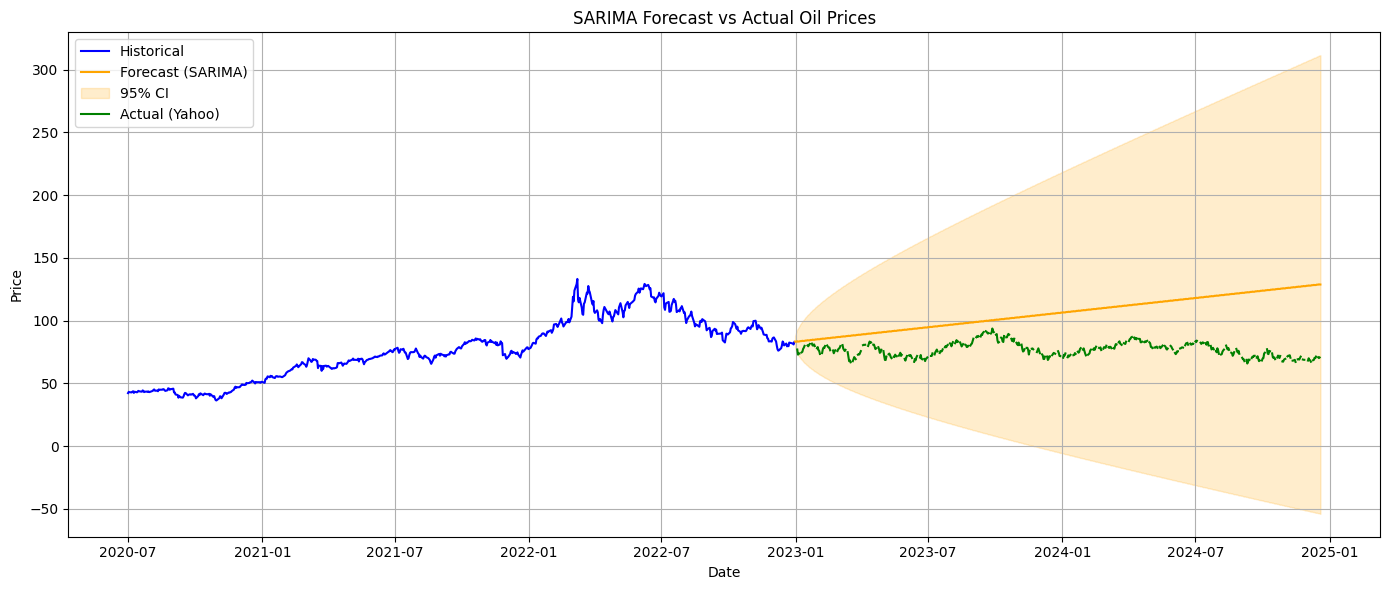

Evaluation Metrics — RMSE: 33.0244, MAE: 29.2623


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- Fit SARIMA Model ---
def fit_sarima_model(series, order=(2, 1, 2), seasonal_order=(1, 1, 1, 7)):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    fitted_model = model.fit(disp=False)
    print(f"Fitted SARIMA{order}x{seasonal_order} — AIC: {fitted_model.aic:.2f}")
    return fitted_model

# --- Forecast & Compare ---
def sarima_forecast_and_evaluate(model, original_series, forecast_days=720):
    # Forecast
    forecast_res = model.get_forecast(steps=forecast_days)
    forecast_mean = forecast_res.predicted_mean
    ci = forecast_res.conf_int()

    # Build forecast DataFrame
    forecast_index = pd.date_range(start=original_series.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
    forecast_df = pd.DataFrame({
        'Forecast': forecast_mean.values,
        'CI_lower': ci.iloc[:, 0].values,
        'CI_upper': ci.iloc[:, 1].values
    }, index=forecast_index)

    # Download actual Yahoo Finance data for Crude Oil Futures (CL=F)
    start_yahoo = forecast_index[0].strftime('%Y-%m-%d')
    end_yahoo = forecast_index[-1].strftime('%Y-%m-%d')
    actual_yahoo = yf.download('CL=F', start=start_yahoo, end=end_yahoo)

    # Clean and align actual Yahoo data
    actual_yahoo = actual_yahoo[['Close']].copy()
    actual_yahoo.columns = ['Actual']
    actual_yahoo.index.name = 'Date'
    actual_yahoo = actual_yahoo[~actual_yahoo.index.duplicated()]

    # Merge forecast with actuals
    combined_df = forecast_df.join(actual_yahoo, how='outer')

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(original_series.index, original_series, label='Historical', color='blue')
    plt.plot(combined_df.index, combined_df['Forecast'], label='Forecast (SARIMA)', color='orange')
    plt.fill_between(combined_df.index, combined_df['CI_lower'], combined_df['CI_upper'], color='orange', alpha=0.2, label='95% CI')
    plt.plot(combined_df.index, combined_df['Actual'], label='Actual (Yahoo)', color='green')
    plt.title('SARIMA Forecast vs Actual Oil Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metrics (only if actual available)
    valid_data = combined_df.dropna()
    if not valid_data.empty:
        rmse = np.sqrt(mean_squared_error(valid_data['Actual'], valid_data['Forecast']))
        mae = mean_absolute_error(valid_data['Actual'], valid_data['Forecast'])
        print(f"Evaluation Metrics — RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    else:
        print("No overlapping actual data available to compute metrics.")

    return combined_df

# --- Example Usage ---
# Assuming you already loaded your dataset into `oil_df_lstm`:
oil_series_sarima = oil_df_lstm['Price']

# Fit SARIMA
sarima_model = fit_sarima_model(oil_series_sarima)

# Forecast and evaluate
sarima_forecast_results = sarima_forecast_and_evaluate(sarima_model, oil_series_sarima)


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def evaluate_sarima_forecast(combined_df: pd.DataFrame) -> None:
    """
    Compute and print forecast evaluation metrics for SARIMA model.

    Parameters:
        combined_df (pd.DataFrame): DataFrame with 'Actual' and 'Forecast' columns.
    """
    if 'Actual' not in combined_df.columns or 'Forecast' not in combined_df.columns:
        print("Error: 'Actual' and 'Forecast' columns must exist in the DataFrame.")
        return

    valid_data = combined_df[['Actual', 'Forecast']].dropna()

    if valid_data.empty:
        print("No valid overlapping data between actual and forecast to evaluate.")
        return

    actual = valid_data['Actual']
    forecast = valid_data['Forecast']

    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    r2 = r2_score(actual, forecast)

    print("SARIMA Forecast Evaluation Metrics:")
    print(f"  RMSE  : {rmse:.4f}")
    print(f"  MAE   : {mae:.4f}")
    print(f"  MAPE  : {mape:.2f}%")
    print(f"  R²    : {r2:.4f}")
evaluate_sarima_forecast(sarima_forecast_results)


SARIMA Forecast Evaluation Metrics:
  RMSE  : 33.0244
  MAE   : 29.2623
  MAPE  : 39.10%
  R²    : -33.0056
